**ОПИСАНИЕ ПРОЕКТА**

В данном проекте используется база данных университета, в которой даны результаты тестирования студентов на предмет выставления рейтинга их преподавателям. Оценки выставляются по результатам обучения в рамках семестра по отдельным дисциплинам.

Задача: построить модель регрессионную модель, которая сможет предсказывать выставленный преподавателю рейтинг.

Данная модель может быть полезной при выстраивании учебного процесса в плане выявление наиболее проблемных зон в преподавательской деятельности. Полученные знания могут использоваться для улучшения образовательной деятельности в вузе.

In [192]:
#импорт библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
import scipy.stats as stats
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import shapiro
from scipy.stats import f_oneway

In [265]:
#читаем данные
pgs_data = pd.read_csv('pgs.csv', sep=';', decimal=',')
pgs_data.head(5)

stud_number  stud_id  group_number  count_group  level  faculty  \
0         6923        1           539           18      1        5   
1        21011        1           539           18      1        5   
2        53121        1           539           18      1        5   
3        57420        1           539           18      1        5   
4        57691        1           539           18      1        5   

   course_study  average_rating  proportion_done  сredit_or_exam  ...  \
0             4             3.5                2             2.0  ...   
1             4             3.5                2             2.0  ...   
2             4             3.5                2             2.0  ...   
3             4             3.5                2             2.0  ...   
4             4             3.5                2             1.0  ...   

   question_2  question_3  question_4  question_5  question_6  question_7  \
0         4.0         4.0         4.0         4.0         4.0         4.0   
1         4.0         4.0         4.0         4.0         4.0         4.0   
2         4.0         4.0         4.0         4.0         4.0         4.0   
3         4.0         4.0         3.0         4.0         3.0         4.0   
4         4.0         4.0         4.0         4.0         4.0         4.0   

   question_8  question_9  attendance  teacher_rating  
0         4.0         NaN         4.0             3.9  
1         4.0         NaN         4.0             4.0  
2         4.0         NaN         4.0             4.0  
3         4.0         NaN         3.0             3.6  
4         4.0         NaN         4.0             4.0  

[5 rows x 33 columns]

In [266]:
pgs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68932 entries, 0 to 68931
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   stud_number            68932 non-null  int64  
 1   stud_id                68932 non-null  int64  
 2   group_number           68932 non-null  int64  
 3   count_group            68932 non-null  int64  
 4   level                  68932 non-null  int64  
 5   faculty                68932 non-null  int64  
 6   course_study           68932 non-null  int64  
 7   average_rating         58546 non-null  float64
 8   proportion_done        68932 non-null  int64  
 9   сredit_or_exam         54242 non-null  float64
 10  student_grade          58080 non-null  float64
 11  discipline_name        68932 non-null  int64  
 12  difficulty_discipline  68932 non-null  int64  
 13  difficulty_on_credits  68932 non-null  int64  
 14  competencies           58508 non-null  float64
 15  te

**Дадим описание признаков**:

0. stud_number - уникальный номер выставления рейтинга
1. stud_id - уникальный номер студента
2. group_number - номер учебной группы
3. count_group - число студентов, обучающихся в группе
4. level - уровень образования (1 - бакалавриат, 2 - магистратура, 3 - специалитет, 4 - аспирантура)
5. faculty - название факультета (изначально зашифрованные факультеты вуза)
6. course_study - курс, на котором обучается студент
7. average_rating - средний балл студента за весь период обучения
8. proportion_done - доля сданных студентом контрольных точек (1 - 100%, 2 - от 90% до 100%, 3 - менее 90%, 4 - нет данных)
9. сredit_or_exam - зачет или экзамен по изучаемой дисциплине (1 - зачет, 2 - экзамен)
10. student_grade - оценка, которую получил студент за дисциплину, по которой выставлял оценку преподавателю
11. discipline_name - название дисциплины (изначально зашифрованные названия)
12. difficulty_discipline - сложность изучаемой дисциплины (1 - простая, 2 - средней сложности, 3 - сложные, 4 - неизвестно)
13. difficulty_on_credits - сложность по частоте получения незачетов (1 - простая, 2 - средней сложности, 3 - сложные, 4 - неизвестно)
14. competencies - формируемые дисциплиной компетенции (1 - профессиональные, 2 - общепрофессиональные, 3 - общекультурные, 4 - другие)
15. teacher_past - признак ведения дисциплины преподавателем раньше (1 - вел, 2 - не вел)
16. fio - ФИО преподавателя (зашифрованы)
17. seriousness - серьезность подхода преподавателя к преподаванию дисциплины (1 - серьезно, 2 - неизвестно)
18. multiplicity - признак множественного ведения дисциплины (1 - на одном факультете, 2 - более, чем на одном факультете)
19. teaching_experience - стаж преподавателя (1 - до 5 лет, 2 - от 5 до 9 лет, 3 - от 10 до 14 лет, 4 - от 15 до 19 лет, 5 - от 20 до 24 лет, 6 - от 25 до 29 лет, 7 - от 30 до 34 лет, 8 - от 35 до 39 лет, 9 - от 40 до 44 лет, 10 - от 45 до 49 лет, 11 - от 50 до 54 лет, 12 - от 55 до 59 лет, 13 - более 60 лет)
20. publication_activity - публикационная активность преподавателя
21. teacher_workload - учебная нагрузка преподавателя
22. question_1 - вопрос к студенту №1
23. question_2 - вопрос к студенту №2
24. question_3 - вопрос к студенту №3
25. question_4 - вопрос к студенту №4
26. question_5 - вопрос к студенту №5
27. question_6 - вопрос к студенту №6
28. question_7 - вопрос к студенту №7
29. question_8 - вопрос к студенту №8
30. question_9 - вопрос к студенту №9
31. attendance - посещаемость студентом занятий (1 - занятия не посещал, 2 - посещал менее половины занятий, 3 - посещал более половины занятий, 4 - в основном посещал все занятия)
32. teacher_rating - рейтинг преподавателя (целевой признак)

**ПРЕДОБРАБОТКА ДАННЫХ**

Рассмотрим датасет на предмет признаков, от которых необходимо отказаться для избежания утечки данных. Это следующие данные: question_1 - question_09 - из этих оценок складывается признак "teacher_rating", если их использовать, то случится утечка данных.

Удалим эти признаки.

Также удалим и признак **stud_number**, поскольку это технический признак, по сути - это номер по порядку

In [267]:
pgs_data = pgs_data.drop(['question_1', 'question_2', 'question_3', 'question_4', 'question_5',
                          'question_6', 'question_7', 'question_8', 'question_9', 'stud_number'], axis=1)

Рассмотрим датасет на предмет пропусков

In [268]:
pgs_data.isnull().mean()

stud_id                  0.000000
group_number             0.000000
count_group              0.000000
level                    0.000000
faculty                  0.000000
course_study             0.000000
average_rating           0.150670
proportion_done          0.000000
сredit_or_exam           0.213109
student_grade            0.157431
discipline_name          0.000000
difficulty_discipline    0.000000
difficulty_on_credits    0.000000
competencies             0.151221
teacher_past             0.000000
fio                      0.000000
seriousness              0.000000
multiplicity             0.000000
teaching_experience      0.001915
publication_activity     0.000000
teacher_workload         0.148886
attendance               0.003685
teacher_rating           0.000000
dtype: float64

Мы видим, что в семи признаках присутствуют пропуски

In [269]:
cols_null_percent = pgs_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

сredit_or_exam         21.310857
student_grade          15.743051
competencies           15.122149
average_rating         15.067023
teacher_workload       14.888586
attendance              0.368479
teaching_experience     0.191493
dtype: float64

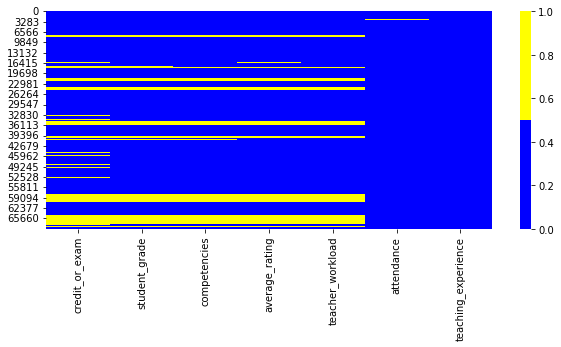

In [270]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    pgs_data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

В целом, пропусков не очень много и можно с ними продолжить работу. Заполним их средними значениями.

In [271]:
#создаем словарь
values = {
    'сredit_or_exam': pgs_data['сredit_or_exam'].median(),
    'average_rating': pgs_data['average_rating'].mean(),
    'student_grade': pgs_data['student_grade'].median(),
    'competencies': pgs_data['competencies'].median(),
    'teaching_experience': pgs_data['teaching_experience'].mean(),
    'teacher_workload': pgs_data['teacher_workload'].mean(),
    'attendance': pgs_data['attendance'].mean()
}
#заполняем пропуски в соответствии с заявленным словарем
pgs_data_clean = pgs_data.fillna(values)

Добавим дополнительные признаки, которые получилось найти из открытых данных.

In [272]:
#читаем выданные данные
dop_data = pd.read_csv('/Users/artemmoskvin/Documents/Data-Science/Data/dop_data.csv', sep=';', decimal=',')
dop_data.head(5)

faculty  head_gender  count_of_departments  institute  \
0        1            2                     5          1   
1        2            2                     3          2   
2        3            2                     1          3   
3        4            1                     3          4   
4        5            1                     8          1   

   direction_of_science  count_vk  
0                     2      1701  
1                     1      1284  
2                     1      5504  
3                     2      1254  
4                     2      1478

Это следующие признаки:
1. head_gender - пол руководителя факульета (1 - мужской, 2 - женский)
2. count_of_departments - количество кафедр на факультете
3. institute - институт, к которому принадлежит факультет (в вузе существует 9 институтов, которые делятся на факультеты)
4. direction_of_science - направление науки (1 - гуманитарные науки, 2 - технические науки, 3 - естественные науки)
5. count_vk - количество подписчиков на группу Вконтакте факультета

In [273]:
pgs_full = pd.merge(pgs_data_clean, dop_data, how='left',on='faculty')

In [274]:
pgs_full.head()

stud_id  group_number  count_group  level  faculty  course_study  \
0        1           539           18      1        5             4   
1        1           539           18      1        5             4   
2        1           539           18      1        5             4   
3        1           539           18      1        5             4   
4        1           539           18      1        5             4   

   average_rating  proportion_done  сredit_or_exam  student_grade  ...  \
0             3.5                2             2.0            1.0  ...   
1             3.5                2             2.0            2.0  ...   
2             3.5                2             2.0            3.0  ...   
3             3.5                2             2.0            2.0  ...   
4             3.5                2             1.0            6.0  ...   

   teaching_experience  publication_activity  teacher_workload  attendance  \
0                  2.0                     0              54.0         4.0   
1                 10.0                     0              44.0         4.0   
2                  2.0                     0              44.0         4.0   
3                  8.0                     0              38.0         3.0   
4                  9.0                     0              29.0         4.0   

   teacher_rating  head_gender  count_of_departments  institute  \
0             3.9            1                     8          1   
1             4.0            1                     8          1   
2             4.0            1                     8          1   
3             3.6            1                     8          1   
4             4.0            1                     8          1   

   direction_of_science  count_vk  
0                     2      1478  
1                     2      1478  
2                     2      1478  
3                     2      1478  
4                     2      1478  

[5 rows x 28 columns]

В итоге, в базе данных получилось **29 признаков**

**РАЗВЕДЫВАТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ**

Рассмотрим углубленно признаки для более полного понимания рассматриваемой базы данных

In [275]:
pgs_full['group_number'].nunique()

589

Видим, что всего в опросе приняли участие студенты 589-ти групп университета

In [276]:
pgs_full['count_group'].mean()

18.81512214936459

В группах обучается в среднем около 19 студентов

In [277]:
pgs_fuculty = pgs_full.groupby('faculty')['group_number'].count()
pgs_fuculty.head(18)

faculty
1      3064
2      3105
3     10234
4      5365
5      4332
6      4699
7      2753
8       436
9      4941
10     4105
11     3263
12     6510
13     2618
14     2728
15     2640
16     3168
17     3325
18     1646
Name: group_number, dtype: int64

In [278]:
pgs_full.groupby('faculty')['group_number'].count().mean()

3829.5555555555557

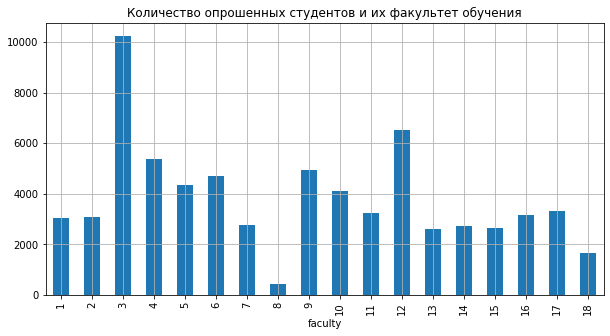

In [279]:
pgs_fuculty.plot(
    kind='bar',
    figsize=(10, 5),
    title='Количество опрошенных студентов и их факультет обучения',
    grid = True
);

В среднем в вузе с одного факультета опрашивается около 4000 студентов, при этом, есть более крупные (до 10234 человек) и более мелкие (до 436 человек) уровни опроса факультетов

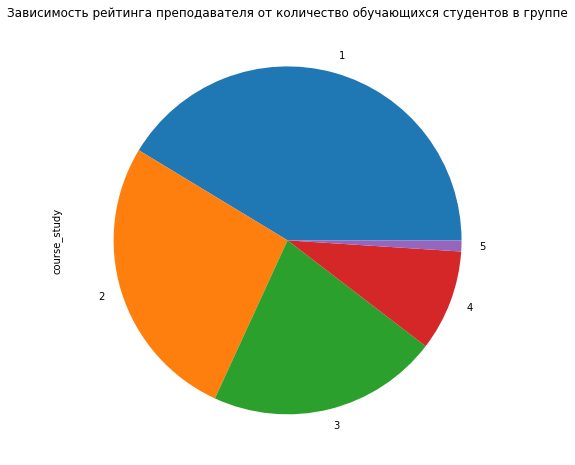

In [280]:
pgs_full_course = pgs_full['course_study'].value_counts()
pgs_full_course.plot(
    kind='pie',
    figsize=(22, 8),
    title='Зависимость рейтинга преподавателя от количество обучающихся студентов в группе',
    grid = True
);

Большинство опрошенных - студенты 1 и 2 курса университета

In [281]:
pgs_full['average_rating'].mean()

4.188149489290472

В целом по университету, студенты получают в основном оценки чуть выше 4

In [282]:
pgs_full['proportion_done'].value_counts()

1    40942
4    10237
3     9135
2     8618
Name: proportion_done, dtype: int64

Значение 4 в наборе данных - означает "нет данных". То есть, по сути это пропуск. Этих данных очень много. Заменим это значение на пропущенное и заменим средним.

In [283]:
pgs_full['proportion_done'] = pgs_full['proportion_done'].replace({4: None})

In [284]:
#создаем словарь
values_prop = {
    'proportion_done': pgs_full['proportion_done'].median()
}
#заполняем пропуски в соответствии с заявленным словарем
pgs_full = pgs_full.fillna(values_prop)

In [285]:
pgs_full['proportion_done'].value_counts()

1.0    51179
3.0     9135
2.0     8618
Name: proportion_done, dtype: int64

Сейчас мы видим более адекватные ситуации данные

In [286]:
pgs_full['сredit_or_exam'].value_counts()

1.0    43686
2.0    25246
Name: сredit_or_exam, dtype: int64

Чаще всего студенты сдают зачеты, чем экзамены

In [287]:
pgs_full['student_grade'].value_counts()

6.0    28004
5.0    14690
1.0    11293
2.0     9171
3.0     4288
7.0      992
4.0      494
Name: student_grade, dtype: int64

Топ-3 оценок по дисциплина, за ведение которых студенты ставят рейтинги преподавателями - это "зачтено", либо "удален с экзамена/зачета", либо оценка "отлично"

In [288]:
pgs_full['discipline_name'].value_counts()

214     2390
351     1739
100     1653
496     1182
115     1174
        ... 
754        1
801        1
353        1
837        1
1218       1
Name: discipline_name, Length: 1293, dtype: int64

In [289]:
pgs_full['discipline_name'].nunique()

1293

Интересно то, что по некоторым дисциплинам выставление рейтинга проводится очень часто, а по некоторым в единичных случаях. Всего оценены 1293 дисциплины

In [290]:
pgs_full['difficulty_discipline'].value_counts()

4    31186
2    28180
3     6798
1     2768
Name: difficulty_discipline, dtype: int64

In [291]:
pgs_full['difficulty_on_credits'].value_counts()

4    29696
2    22693
1    13990
3     2553
Name: difficulty_on_credits, dtype: int64

Проблема с двумя данными признаками в том, что более 30 процентов занимает значение 4, что означает "неизвестно", что, по сути, является пропущенными значениями. Удалим их.

In [292]:
pgs_full.drop(['difficulty_discipline', 'difficulty_on_credits'], axis = 1, inplace=True)

In [293]:
pgs_full['competencies'].value_counts()

2.0    36317
1.0    18079
3.0    14328
4.0      208
Name: competencies, dtype: int64

Чаще всего студентов просят оценить дисциплины, по которым они получают общепрофесииональные компетенции

In [294]:
pgs_full['teacher_past'].value_counts()

2    49990
1    18942
Name: teacher_past, dtype: int64

Большинство преподавателей не вели оцениваемую дисциплину в прошлом. Можно сделать предположение, что политика университета состоит в частичном ранжировании преподавателей по провоидимым дисциплиным

In [295]:
pgs_full['fio'].nunique()

828

Всего оценено 828 преподавателей

In [296]:
pgs_full['seriousness'].value_counts()

2    66435
1     2497
Name: seriousness, dtype: int64

Здесь также значение 2 - "неизвестно". Придется удалить

In [297]:
pgs_full.drop(['seriousness'], axis = 1, inplace=True)

In [298]:
pgs_full['multiplicity'].value_counts()

1    56133
2    12799
Name: multiplicity, dtype: int64

Большинство преподавателей работают в рамках одного факультета

In [299]:
pgs_full['teaching_experience'].median()

5.0

In [300]:
age_fuculty = pgs_full.groupby('faculty')['teaching_experience'].mean()
age_fuculty.head(18)

faculty
1     6.027751
2     5.138164
3     4.153457
4     5.635042
5     6.473915
6     5.274697
7     5.688340
8     5.011468
9     5.662619
10    5.421421
11    5.947594
12    5.640707
13    4.801375
14    4.982405
15    5.379476
16    5.584912
17    5.763308
18    6.019441
Name: teaching_experience, dtype: float64

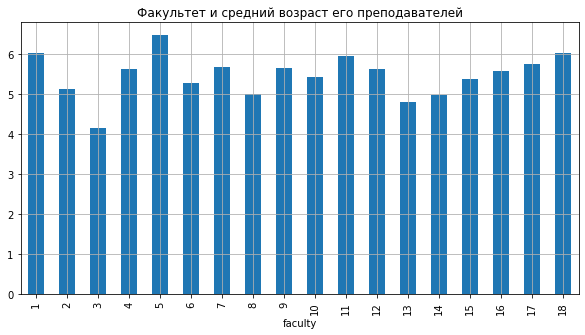

In [301]:
age_fuculty.plot(
    kind='bar',
    figsize=(10, 5),
    title='Факультет и средний возраст его преподавателей',
    grid = True
);

Наиболее популярный стаж преподавателей вуза - 20-24 года. Вуз - не молодой, но и не совсем возрастной. Причем, данная ситуация примерно одинакова на всех факультетах. Выделяется молодой факультет №3 и возрастной факультет №5

In [302]:
pgs_full['publication_activity'].mean()

2.248186618696687

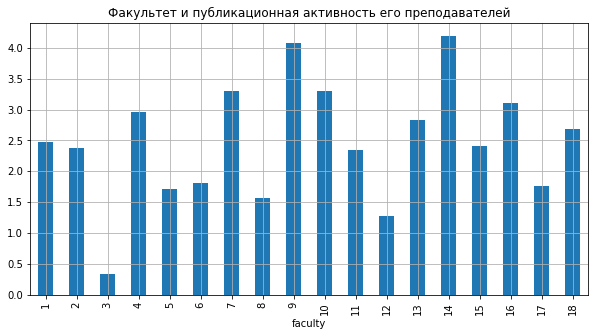

In [303]:
public_fuculty = pgs_full.groupby('faculty')['publication_activity'].mean()
public_fuculty.plot(
    kind='bar',
    figsize=(10, 5),
    title='Факультет и публикационная активность его преподавателей',
    grid = True
);

В среднем публикационная активность преподавателей - 2,2 статьи в год. При этом, распределение по университету далеко не равномерное. Низкой активностью выделяются факультеты №3 и №8, а высокой факультеты №9 и №14

In [304]:
pgs_full['teacher_workload'].mean()

72.4404302101621

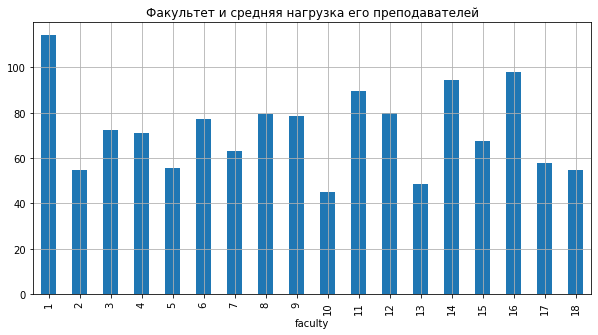

In [305]:
work_fuculty = pgs_full.groupby('faculty')['teacher_workload'].mean()
work_fuculty.plot(
    kind='bar',
    figsize=(10, 5),
    title='Факультет и средняя нагрузка его преподавателей',
    grid = True
);

Средняя нагрузка преподаватей в среднем - 72 часа. Ситуация с нагрузкой примерно одинакова во всем вузе, при этом на факультете №1 нагрузка на преподавателей наиболее высока, а на факультетах №10 и №13, наоборот, низкая

In [306]:
pgs_full['teacher_rating'].mean()

3.734137991063656

Интересно, что средний рейтинг в 3,7 примерно одинаков для всего вуза

In [307]:
pgs_full['head_gender'].value_counts()

2    40445
1    28487
Name: head_gender, dtype: int64

Больше всего руководителей в университете женщин

In [308]:
pgs_full['count_of_departments'].mean()

4.175593338362444

Среднее количество кафедр на факультете - 4

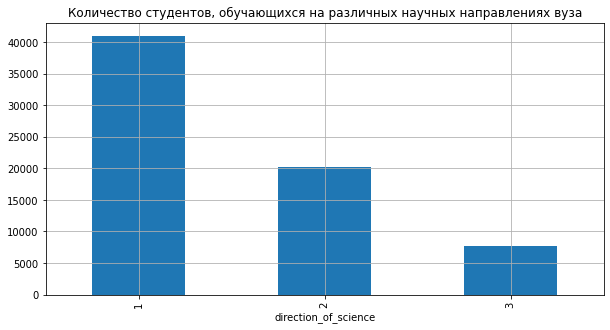

In [309]:
dir_rat = pgs_full.groupby('direction_of_science')['group_number'].count()
dir_rat.plot(
    kind='bar',
    figsize=(10, 5),
    title='Количество студентов, обучающихся на различных научных направлениях вуза',
    grid = True
);

Наиболее популярное направление - гуманитарное, естественно-научное - наименее популярное

In [310]:
pgs_full['count_vk'].mean()

2581.230096326815

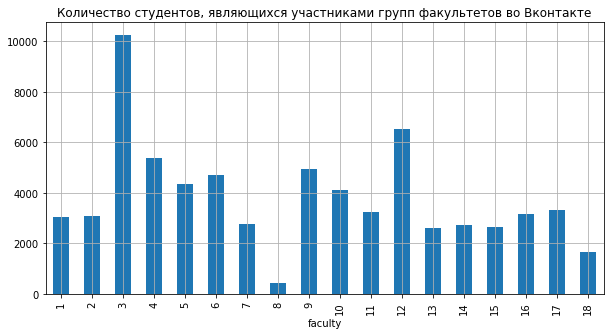

In [311]:
fack_vk = pgs_full.groupby('faculty')['count_vk'].count()
fack_vk.plot(
    kind='bar',
    figsize=(10, 5),
    title='Количество студентов, являющихся участниками групп факультетов во Вконтакте',
    grid = True
);

Распределение факультетов по онлайн-активности разнообразное. В среднем - около 2500 человек. Но есть и более крупные (факультет №3 - более 10000 человек) и менее крупыне (факультет №8 - около 300 человек) группы.

Рассмотрим датасет на предмет мультиколлениарности

In [312]:
# создаем функцию для построения корреляционной диаграммы
def show_corr_heatmap(columns_list, title, method):
    """Построения корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = pgs_full[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()

Рассмотрим количественные данные

In [313]:
#выделим количественные признаки
num_cols = ['count_group', 'average_rating', 'publication_activity',
            'teacher_workload', 'teacher_rating', 'count_vk']

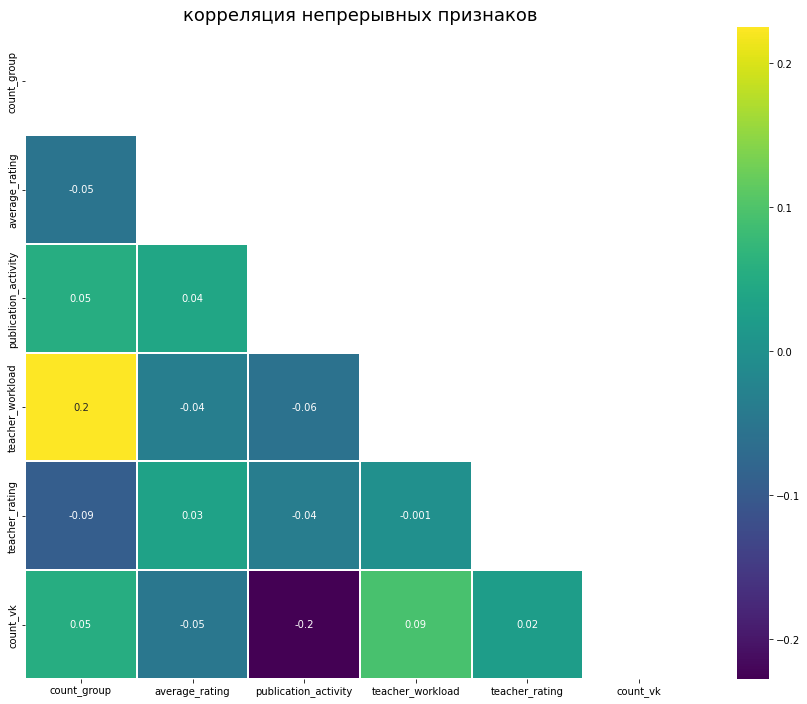

In [314]:
# строим диаграмму для непрерывных признаков:
show_corr_heatmap(
    num_cols, 
    'корреляция непрерывных признаков', 
    method='spearman'
);

В данных признаках мультиколлинеарность отсутствует. Рассмотрим дополнительно мультиколлинеарность между всеми признаками в целом.

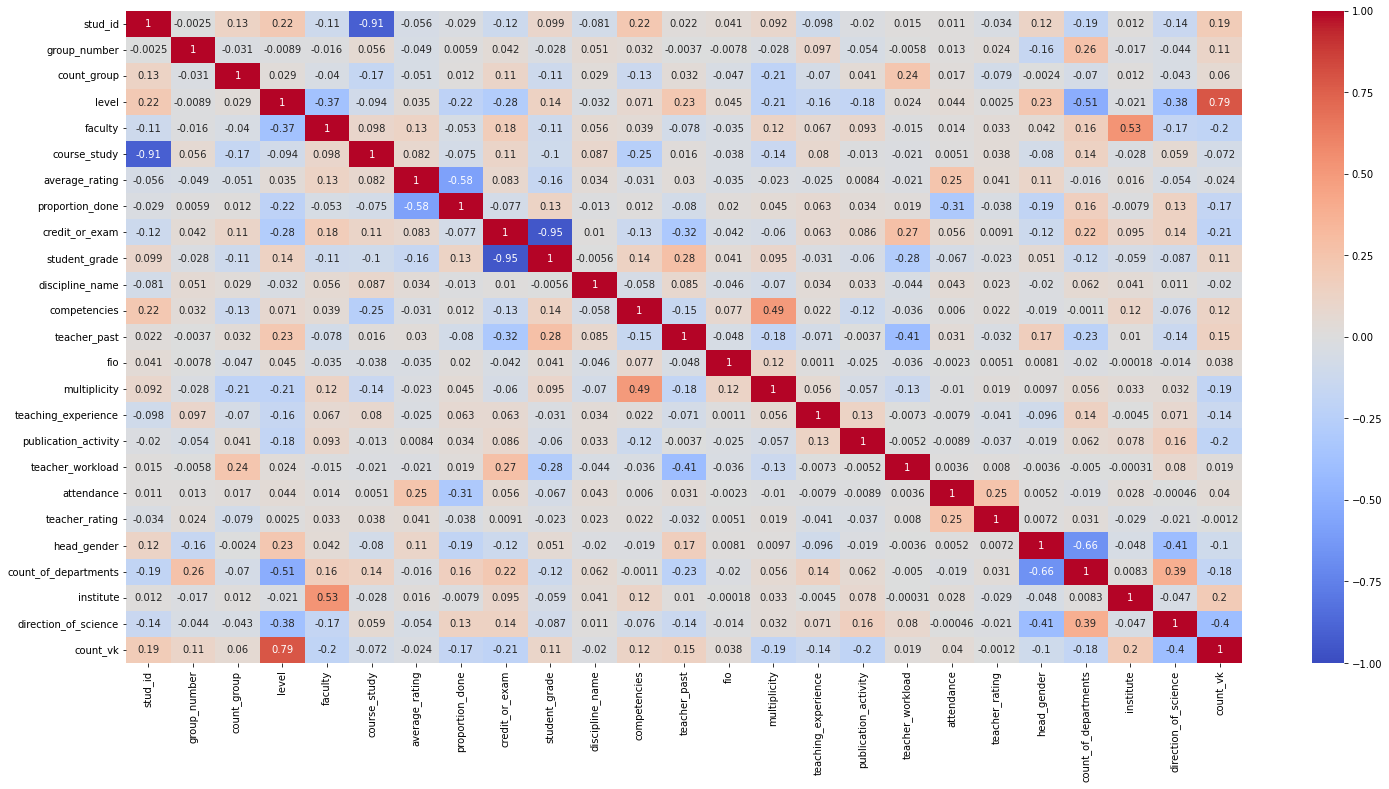

In [315]:
fig_, ax_ = plt.subplots(figsize=(25, 12))
dataplot = sns.heatmap(pgs_full.corr(), cmap= 'coolwarm', annot=True, vmin=-1, vmax=1, center= 0)

Удалим признаки, которые вызывают мультиколлинеарность

In [316]:
# удаляем признаки, которые могут привести к мультиколлинеарности
pgs_full.drop(['stud_id', 'level', 'student_grade'], axis = 1, inplace=True)

Взгляд на корреляции между признаками и целевой переменной говорит нам о том, что между ними слишком мало значимых корреляций. Самая крупная корреляция - 0,25 между признаком "attendance" и целевой переменной. Рассмотрим эту взаимосвязь более пристально

Проверим целевую переменную на нормальность распределения

In [317]:
#установим показатели для определения типа распределения
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально'
#установим уровень значимости
alpha = 0.05
#создадим функцию, проверающую нормальность распределения
def normaltest(feat):
    _, p = shapiro(pgs_full[feat])
    print('p=%.3f' % p)
    if p > alpha:
        print(H0)
    else:
        print(Ha)

In [318]:
normaltest('teacher_rating')

p=0.000
Данные не распределены нормально


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Text(0.5, 1.0, 'Распределение рейтинга преподавателей')

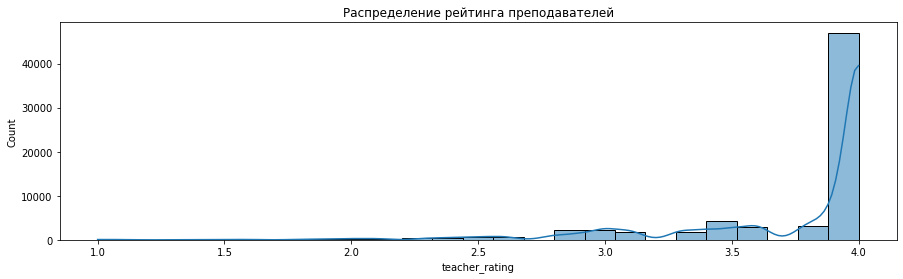

In [319]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
sns.histplot(
    data=pgs_full,
    x='teacher_rating',
    bins=25,
    kde=True
);
axes.set_title("Распределение рейтинга преподавателей")

Распределение ненормальное, поэтому воспользуемся однофакторным дисперсионным анализом 

In [320]:
_, p = f_oneway(pgs_full['attendance'], pgs_full['teacher_rating'])
H00 = 'Нет значимой разницы между посещаемостью и выставляемым рейтингом'
Haa = 'Есть значимая разница между посещаемостью и выставляемым рейтингом.'
if p>alpha:
  print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. {H00}")
else:
  print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу. {Haa}")

2.993802308510474e-21 <= 0.05. Мы отвергаем нулевую гипотезу. Есть значимая разница между посещаемостью и выставляемым рейтингом.


Для того, чтоб понять, нужно или нет проводить нормализацию, посмотрим на нормальность распределения количественных признаков

Признак 'count_group':

In [321]:
normaltest('count_vk')

p=0.000
Данные не распределены нормально


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Признак 'average_rating':

In [322]:
normaltest('average_rating')

p=0.000
Данные не распределены нормально


Признак 'publication_activity':

In [323]:
normaltest('publication_activity')

p=0.000
Данные не распределены нормально


Признак 'teacher_workload':

In [324]:
normaltest('teacher_workload')

p=0.000
Данные не распределены нормально


Признак 'count_group':

In [325]:
normaltest('count_group')

p=0.000
Данные не распределены нормально


Видим, что во всем датасете мы имеем дело с данными, которые не имеют нормального распределения. Поэтому, на следующем этапе нужно будет провести нормализацию данных

**ПОСТРОЕНИЕ РЕГРЕССИОННЫХ МОДЕЛЕЙ**

Для удобства сделаем копию данных

In [326]:
pgs_full_ml = pgs_full.copy()

Разобъем данные на обучающую, валидационноую и тестовую выборку в пропорции 70/15/15

In [327]:
X = pgs_full_ml.drop(['teacher_rating'], axis=1)
y = pgs_full_ml['teacher_rating']

In [328]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.30, random_state=42
)

In [329]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                train_size=0.5, random_state=42)

Сейчас у нас есть три подвыборки: тренировочная (для обучения), тестовая (для подбора гиперпараметров), валидационная (для определения метрики)

Выделим признаки датасета для того, чтоб в дальнейшем определять лучшие показатели. Отказываться от каких-либо признаков не будем, поскольку их и так немного

In [330]:
selector = SelectKBest(score_func=f_regression, k=21)
selector.fit(X_train, y_train)
selector.get_feature_names_out()
best_features = selector.get_feature_names_out()

Поскольку многие признаки распределены ненормально, проведем нормализацию

In [331]:
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)
X_val = mm_scaler.transform(X_val)

Для начала попробуем построить простые модели: линейную регрессию и деревья решений. В процессе построения модели, будем пользоваться метрикой р-квадрат

Построим модель линейной регрессии

In [333]:
#Создаём объект класса LinearRegression
lr_model = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_model.fit(X_train, y_train)
y_pred_train = lr_model.predict(X_train)
y_pred_val = lr_model.predict(X_val)
print('r2_score на тренировочном наборе: {:.3f}'.format(r2_score(y_train, y_pred_train)))
print('r2_score на валидационном наборе: {:.3f}'.format(r2_score(y_val, y_pred_val)))

r2_score на тренировочном наборе: 0.081
r2_score на валидационном наборе: 0.087


Линейная регрессия на настройках по умолчанию показывает очень низкие показатели метрики р-квадрат. Попробуем настроить гиперпараметры модели

In [334]:
parameters={'fit_intercept':[True, False], 'copy_X':[True, False], 'positive':[True, False], 'n_jobs':[True, False]}
grid_search_lr = GridSearchCV(
    estimator=lr_model, 
    param_grid=parameters, 
    cv=5, 
    n_jobs=-1
)
grid_search_lr.fit(X_test, y_test)
print("Наилучшие значения гиперпараметров: {}".format(grid_search_lr.best_params_))
print("Лучшая метрика R-квадрат на тестовой выборке: {:.3f}".format(grid_search_lr.best_score_))
best_model_lr = grid_search_lr.best_estimator_
best_model_lr.fit(X_train, y_train)
y_pred_train = best_model_lr.predict(X_train)
y_pred_val = best_model_lr.predict(X_val)
print('Лучшая метрика R-квадрат на тренировочной выборке: {:.3f}'.format(r2_score(y_train, y_pred_train)))
print('Лучшая метрика R-квадрат на валидационной выборке: {:.3f}'.format(r2_score(y_val, y_pred_val)))

Наилучшие значения гиперпараметров: {'copy_X': True, 'fit_intercept': True, 'n_jobs': True, 'positive': False}
Лучшая метрика R-квадрат на тестовой выборке: 0.092
Лучшая метрика R-квадрат на тренировочной выборке: 0.081
Лучшая метрика R-квадрат на валидационной выборке: 0.087


Видно, что метрики не улучшились. Воспользуемся моделью полиномиальной регрессии

In [335]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.fit_transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.fit_transform(X_test)
#Генерируем полиномиальные признаки для валидационной выборки
X_val_poly = poly.fit_transform(X_val)
#Создаём объект класса LinearRegression с наилучшими гиперпараметрами
lr_model_poly = linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=True, positive=False)
#Обучаем модель
lr_model_poly.fit(X_train_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#Делаем предсказание для валидационной выборки
y_val_predict_poly = lr_model_poly.predict(X_val_poly)
print('r2_score на тренировочном наборе: {:.3f}'.format(r2_score(y_train, y_train_predict_poly)))
print('r2_score на тестовом наборе: {:.3f}'.format(r2_score(y_val, y_val_predict_poly)))

r2_score на тренировочном наборе: 0.121
r2_score на тестовом наборе: 0.116


Ситуация улучшилась, но все равно метрики слишком низкие

Построим модель дерева решений

In [336]:
#Создаём объект класса DecisionTreeClassifier
dt_model = tree.DecisionTreeRegressor()
#Обучаем модель
dt_model.fit(X_train, y_train)
#Делаем предсказание
y_pred_train = dt_model.predict(X_train)
y_pred_val = dt_model.predict(X_val)
print('r2_score на тренировочном наборе: {:.3f}'.format(r2_score(y_train, y_pred_train)))
print('r2_score на тестовом наборе: {:.3f}'.format(r2_score(y_val, y_pred_val)))

r2_score на тренировочном наборе: 0.811
r2_score на тестовом наборе: -0.321


Видим здесь сильное переобучение. Попробуем определить наилучшие гиперпараметры модели с помощью Gread Search

In [337]:
param_distributions = {'max_depth': list(np.linspace(2, 10, dtype=int)),
                       'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
                       'min_samples_split':np.arange(2, 10, step=2)}
grid_search_dt = GridSearchCV(
    estimator=dt_model, 
    param_grid=param_distributions,
    scoring='r2',
    cv=5, 
    n_jobs=-1
)
grid_search_dt.fit(X_test, y_test)
print("Наилучшие значения гиперпараметров: {}".format(grid_search_dt.best_params_))
print("Лучшая метрика R-квадрат на тестовой выборке: {:.3f}".format(grid_search_dt.best_score_))
best_model_dt = grid_search_dt.best_estimator_
best_model_dt.fit(X_train, y_train)
y_pred_train = best_model_dt.predict(X_train)
y_pred_val = best_model_dt.predict(X_val)
print('Лучшая метрика R-квадрат на тренировочной выборке: {:.3f}'.format(r2_score(y_train, y_pred_train)))
print('Лучшая метрика R-квадрат на валидационной выборке: {:.3f}'.format(r2_score(y_val, y_pred_val)))

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_leaf': 24, 'min_samples_split': 4}
Лучшая метрика R-квадрат на тестовой выборке: 0.088
Лучшая метрика R-квадрат на тренировочной выборке: 0.128
Лучшая метрика R-квадрат на валидационной выборке: 0.107


На лучших гиперпараметрах дерево решений не особенно сильно отличается от полиномиальной регрессии. Метрики слишком низкие

Перейдем к ансамблевым моделям: случайный лес и градиентный бустинг

Построим модель случайныйного леса

In [338]:
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train, y_train)
y_pred_train_rf = rf_regr.predict(X_train)
y_pred_val_rf = rf_regr.predict(X_val)
print('r2_score на тренировочном наборе: {:.3f}'.format(r2_score(y_train, y_pred_train_rf)))
print('r2_score на тестовом наборе: {:.3f}'.format(r2_score(y_val, y_pred_val_rf)))

r2_score на тренировочном наборе: 0.740
r2_score на тестовом наборе: 0.146


Видим очень сильное переобучение. Подберем гиперпараметры

In [339]:
param_grid = {'n_estimators': list(np.linspace(10, 80, 10, dtype=int)),
              'min_samples_leaf': list(np.linspace(3, 7, 1, dtype=int)),
              'min_samples_split': list(np.linspace(3, 7, 1, dtype=int)),
              'max_depth': list(np.linspace(15, 40, 1, dtype=int)),
              'max_features': ['sqrt', 'log2', None]
              }

grid_search_rf = GridSearchCV(
    estimator=rf_regr, 
    param_grid=param_grid,
    scoring='r2',
    cv=5, 
    n_jobs=-1
)
grid_search_rf.fit(X_test, y_test)
print("Наилучшие значения гиперпараметров: {}".format(grid_search_rf.best_params_))
print("Лучшая метрика R-квадрат на тестовой выборке: {:.3f}".format(grid_search_rf.best_score_))
best_model_rf = grid_search_rf.best_estimator_
best_model_rf.fit(X_train, y_train)
y_pred_train = best_model_rf.predict(X_train)
y_pred_val = best_model_rf.predict(X_val)
print('Лучшая метрика R-квадрат на тренировочной выборке: {:.3f}'.format(r2_score(y_train, y_pred_train)))
print('Лучшая метрика R-квадрат на валидационной выборке: {:.3f}'.format(r2_score(y_val, y_pred_val)))

Наилучшие значения гиперпараметров: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 64}
Лучшая метрика R-квадрат на тестовой выборке: 0.156
Лучшая метрика R-квадрат на тренировочной выборке: 0.379
Лучшая метрика R-квадрат на валидационной выборке: 0.219


Метрики заметно выросли и переобучение не слишком большое, но все равно оно значимо (разница порядка 0,16)

Построим модель градиентного бустинга

In [340]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
y_pred_train_gb = gb_model.predict(X_train)
y_pred_val_gb = gb_model.predict(X_val)
print('r2_score на тренировочном наборе: {:.3f}'.format(r2_score(y_train, y_pred_train_gb)))
print('r2_score на тестовом наборе: {:.3f}'.format(r2_score(y_val, y_pred_val_gb)))

r2_score на тренировочном наборе: 0.146
r2_score на тестовом наборе: 0.135


Переобучение минимальное, но метрики вновь слишком низкие. Попробуем подобрать гиперпараметры

In [341]:
parametrs = {'learning_rate':[0.01, 0.02, 0.03, 1, 10, 100],
             'subsample': [0.09, 0.05, 0.02],
             'n_estimators': [100, 500, 1000],
             'max_depth': list(np.linspace(15, 40, 1, dtype=int))}
grid_search_gb = GridSearchCV(
    estimator=gb_model, 
    param_grid=parametrs,
    scoring='r2',
    cv=5, 
    n_jobs=-1
)
grid_search_gb.fit(X_test, y_test)
print("Наилучшие значения гиперпараметров: {}".format(grid_search_gb.best_params_))
print("Лучшая метрика R-квадрат на тестовой выборке: {:.3f}".format(grid_search_gb.best_score_))
best_model_gb = grid_search_gb.best_estimator_
best_model_gb.fit(X_train, y_train)
y_pred_train = best_model_gb.predict(X_train)
y_pred_val = best_model_gb.predict(X_val)
print('Лучшая метрика R-квадрат на тренировочной выборке: {:.3f}'.format(r2_score(y_train, y_pred_train)))
print('Лучшая метрика R-квадрат на валидационной выборке: {:.3f}'.format(r2_score(y_val, y_pred_val)))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:231: RuntimeWarning: overflow encountered in square
  * np.sum(sample_weight * ((y - raw_predictions.ravel()) ** 2))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:634: RuntimeWarning: invalid value encountered in double_scalars
  self.oob_improvement_[i] = old_oob_score - loss_(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:231: RuntimeWarnin

Наилучшие значения гиперпараметров: {'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 500, 'subsample': 0.09}
Лучшая метрика R-квадрат на тестовой выборке: 0.128
Лучшая метрика R-квадрат на тренировочной выборке: 0.442
Лучшая метрика R-квадрат на валидационной выборке: 0.223


Метрика на тренировочной выборке выросла, но на валидационной она слишком низка. Переобучение достаточно высокое (разница 0,21)

Все модели получились низкого качества. Проблема скорее всего в том, что слишком мало значимых данных. Нужно набирать больше признаков, связанных непосредственно со студентами (пол, возраст, происхождение, место жительства и прочее). Прямо сейчас такие данные нет возможности

При этом, лучшая модель из получившихся - случайный лес, поскольку переобучение в ней наиболее минимальное - 0,16. Найдем лучшие признаки, на которых основывается построение данной модели

In [342]:
features = pd.Series(
    data=best_model_rf.feature_importances_,
    index=best_features)
features.sort_values(ascending=False, inplace=True)

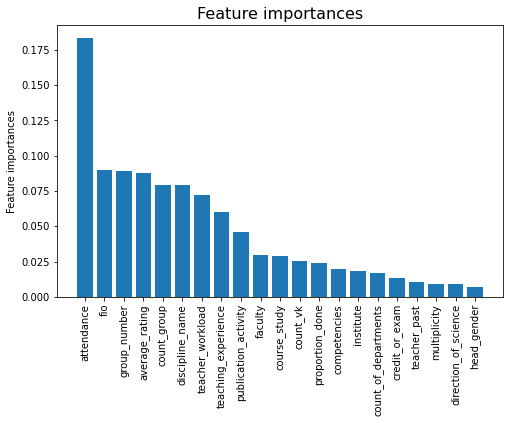

In [343]:
fig, axes = plt.subplots(figsize=(8, 5))
plt.bar(features.index,  features.values)
axes.xaxis.set_tick_params(rotation=90)
axes.set_title('Feature importances', fontsize=16)
axes.set_ylabel('Feature importances');

Наиболее значимыми показателями для построения модели являются:
- посещаемость занятий
- ФИО преподавателя
- номер группы
- средняя оценка студента за весь период обучения

Проект можно улучшить, собрав больше данных о студентах.